In [3]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf

from models.tsnormalization import TimeNormalization

In [4]:
df = pd.read_csv('../data/AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


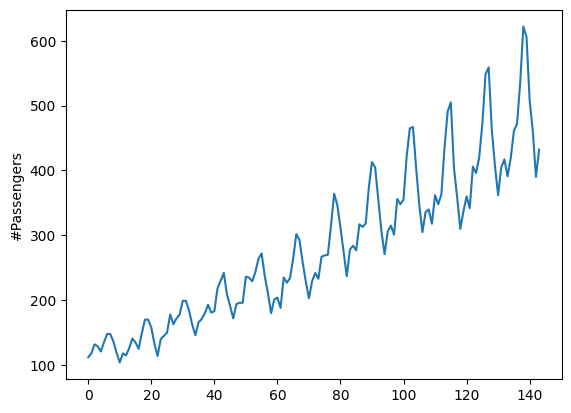

In [5]:
fig, ax = plt.subplots()

sns.lineplot(x=range(len(df)), y='#Passengers', data=df, ax=ax)
plt.show()

In [26]:
val_periods = 30
test_periods = 20
df_train = df.iloc[:-(val_periods + test_periods), :]
df_val = df.iloc[-(val_periods + test_periods):-test_periods, :]
df_test = df.iloc[-test_periods:, :]

print(f"{len(df)} = {len(df_train)} + {len(df_val)} + {len(df_test)}")

train_periods = len(df_train)

144 = 94 + 30 + 20


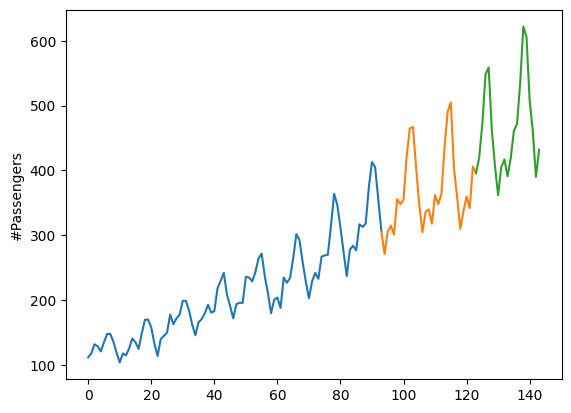

In [27]:
fig, ax = plt.subplots()

sns.lineplot(x=range(train_periods), y='#Passengers', data=df_train, ax=ax)
sns.lineplot(x=range(train_periods - 1, train_periods + val_periods), y='#Passengers', data=pd.concat([df_train.tail(1), df_val]), ax=ax)
sns.lineplot(
    x=range(
    train_periods + val_periods - 1, train_periods + val_periods + test_periods
    ),
    y='#Passengers',
    data=pd.concat([df_val.tail(1), df_test]),
    ax=ax
)
plt.show()

In [28]:
def transform_list(timeseries: list, input_timesteps: int, output_timesteps: int) -> tf.Tensor:
    len_timeseries = len(timeseries)
    input_timeseries = []
    output_timeseries = []
    for index in range(len_timeseries - (input_timesteps + output_timesteps - 1)):
        input_timeseries_item = timeseries[index:(index + input_timesteps)]
        output_timeseries_item = timeseries[(index + input_timesteps):(index + input_timesteps + output_timesteps)]
        input_timeseries.append(input_timeseries_item)
        output_timeseries.append(output_timeseries_item)
    return tf.convert_to_tensor(input_timeseries, dtype=tf.float32), tf.convert_to_tensor(output_timeseries, dtype=tf.float32)

In [40]:
periods = 12
buffer_size = 10000
batch_size = 16

def input_expand_dims(input_tensor, output_tensor):
    return tf.expand_dims(input_tensor, axis=-1), output_tensor


def convert_dataframe_to_tfdataset(dataframe, periods):
    dataset = tf.data.Dataset.from_tensor_slices(transform_list(dataframe['#Passengers'].tolist(), periods, 1))
    dataset = dataset.map(input_expand_dims)
    return dataset

dataset = convert_dataframe_to_tfdataset(df, periods=periods)
train_dataset = dataset.take(train_periods).repeat().shuffle(buffer_size).batch(batch_size)
val_dataset = dataset.take(val_periods).batch(1000).cache()

In [41]:
input_layer = tf.keras.layers.Input(shape=[periods, 1])
x, mean, std = TimeNormalization()(input_layer)
x = tf.keras.layers.LSTM(
    units=100,
    return_sequences=True,
    activation='tanh'
)(x)
x = tf.keras.layers.LSTM(
    units=50,
    return_sequences=True,
    activation='tanh'
)(x)
x = tf.keras.layers.LSTM(
    units=25,
    return_sequences=False,
    activation='tanh'
)(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(units=1, activation='linear')(x)
ouput = std * x + mean

model = tf.keras.Model(input_layer, ouput)

model.compile(loss='mae', optimizer='adam')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model.fit(train_dataset, epochs=1000, steps_per_epoch=100, callbacks=[early_stopping], validation_data=val_dataset)

Epoch 1/1000
100/100 [==============================] - 7s 27ms/step - loss: 16.4609 - val_loss: 8.1485
Epoch 2/1000
100/100 [==============================] - 1s 14ms/step - loss: 12.5925 - val_loss: 8.8405
Epoch 3/1000
100/100 [==============================] - 1s 13ms/step - loss: 11.9844 - val_loss: 7.7403
Epoch 4/1000
100/100 [==============================] - 1s 13ms/step - loss: 12.0037 - val_loss: 8.1845
Epoch 5/1000
100/100 [==============================] - 1s 13ms/step - loss: 10.9546 - val_loss: 7.3614
Epoch 6/1000
100/100 [==============================] - 1s 13ms/step - loss: 11.1702 - val_loss: 7.8555
Epoch 7/1000
100/100 [==============================] - 1s 13ms/step - loss: 11.3756 - val_loss: 7.6550
Epoch 8/1000
100/100 [==============================] - 1s 13ms/step - loss: 10.2931 - val_loss: 9.0039
Epoch 9/1000
100/100 [==============================] - 1s 13ms/step - loss: 10.5155 - val_loss: 6.9323
Epoch 10/1000
100/100 [==============================] - 1s 13ms

In [42]:
def long_term_predict(model, initial_data, timesteps=40):
    initial_shape = initial_data.shape
    new_data = initial_data
    step = 0
    while step < timesteps:
        input_data = new_data[:, -initial_shape[-2]:, :]
        print(input_data)
        simple_pred = model.predict(input_data)
        print(tf.expand_dims(simple_pred, axis=0))
        new_data = tf.concat([new_data, tf.cast(tf.expand_dims(simple_pred, axis=0), tf.float32)], axis=-2)
        step += 1
    return new_data

tf.Tensor(
[[[363.]
  [435.]
  [491.]
  [505.]
  [404.]
  [359.]
  [310.]
  [337.]
  [360.]
  [342.]
  [406.]
  [396.]]], shape=(1, 12, 1), dtype=float32)
1/1 [==============================] - 0s 46ms/step
tf.Tensor([[[411.84262]]], shape=(1, 1, 1), dtype=float32)
tf.Tensor(
[[[435.     ]
  [491.     ]
  [505.     ]
  [404.     ]
  [359.     ]
  [310.     ]
  [337.     ]
  [360.     ]
  [342.     ]
  [406.     ]
  [396.     ]
  [411.84262]]], shape=(1, 12, 1), dtype=float32)
1/1 [==============================] - 0s 27ms/step
tf.Tensor([[[480.7957]]], shape=(1, 1, 1), dtype=float32)
tf.Tensor(
[[[491.     ]
  [505.     ]
  [404.     ]
  [359.     ]
  [310.     ]
  [337.     ]
  [360.     ]
  [342.     ]
  [406.     ]
  [396.     ]
  [411.84262]
  [480.7957 ]]], shape=(1, 12, 1), dtype=float32)
1/1 [==============================] - 0s 25ms/step
tf.Tensor([[[544.96423]]], shape=(1, 1, 1), dtype=float32)
tf.Tensor(
[[[505.     ]
  [404.     ]
  [359.     ]
  [310.     ]
  [337.     ]
  

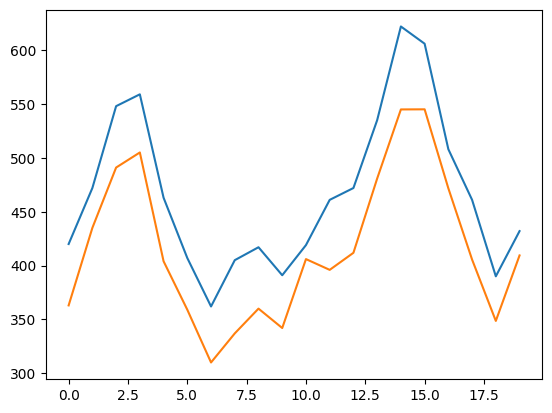

In [45]:
initial_data = tf.cast(tf.reshape(df_val.tail(periods)['#Passengers'].tolist(), [1, periods, 1]), tf.float32)
new_data = long_term_predict(model, initial_data)
plt.plot(df_test['#Passengers'].tolist())
plt.plot(new_data.numpy()[0, :, 0][:len(df_test)].tolist())
plt.show()